In [1]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
data_dir = "TB_Chest_Radiography_Database"

PreProcessing & Augmentation



In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize images to 224x224 to fit into CNN models
    transforms.ToTensor(),  # Convert images to PyTorch tensors [0, 1]
    transforms.Normalize(mean=[0.5], std=[0.5]) # Normalize images to [-1, 1]
])
                         

In [4]:
datasets = datasets.ImageFolder(root=data_dir, transform=transform) # Load dataset from directory

In [5]:
train_size = int(0.7 * len(datasets)) # 70% for training
val_size = int(0.15 * len(datasets)) # 15% for validation
test_size = len(datasets) - train_size - val_size # 15% for testing

In [6]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(datasets, [train_size, val_size, test_size])

In [7]:
train_loader = DataLoader(datasets, batch_size=32, shuffle=True) #  randomize the order of samples every epoch so the model doesn’t memorize a fixed sequence.
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) # false =no shuffle
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

In [8]:
print(f"Train: {len(train_dataset)} samples | Val: {len(val_dataset)} samples | Test: {len(test_dataset)} samples")
print("Classes", datasets.classes) # ['Normal', 'TB']

Train: 2940 samples | Val: 630 samples | Test: 630 samples
Classes ['Normal', 'Tuberculosis']


In [9]:
total = len(datasets)
print(f"Train: {len(train_dataset)} ({len(train_dataset)/total:.1%})")
print(f"Val: {len(val_dataset)} ({len(val_dataset)/total:.1%})")
print(f"Test: {len(test_dataset)} ({len(test_dataset)/total:.1%})")


Train: 2940 (70.0%)
Val: 630 (15.0%)
Test: 630 (15.0%)


DenseNet-121

In [10]:
import torch.nn as nn
import torchvision.models as models

In [11]:
model = models.densenet121(weights=True) # Load pre-trained DenseNet-121 model

c:\Users\mboug\Desktop\TB\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers except the last one

In [13]:
# Unfreeze the last dense block and classifier for fine-tuning -> This lets the model adapt high-level features to TB X-rays without destroying the low-level ones.
for param in model.features.denseblock4.parameters():
    param.requires_grad = True  

for param in model.classifier.parameters():
    param.requires_grad = True  # 

In [14]:
# Replace the classifier with a new one for binary classification
num_features = model.classifier.in_features  # Get the number of input features to the classifier
model.classifier = nn.Linear(num_features, 2)  # Replace the classifier with a new one for binary classification

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
model = model.to(device)

Training

In [17]:
criterion = nn.CrossEntropyLoss() #Loss Function
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)  

In [18]:
num_epochs = 5 

In [23]:
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, total_train = 0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()
        total_train += labels.size(0)
    
    train_acc = train_correct / total_train
    train_loss = train_loss / total_train

    model.eval()
    val_loss, val_correct, total_val = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            total_val += labels.size(0)
    
    val_acc = val_correct / total_val
    val_loss = val_loss / total_val

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch [1/5] Train Loss: 0.0307 | Train Acc: 0.9902 Val Loss: 0.0193 | Val Acc: 0.9984
Epoch [2/5] Train Loss: 0.0268 | Train Acc: 0.9921 Val Loss: 0.0242 | Val Acc: 0.9905
Epoch [3/5] Train Loss: 0.0259 | Train Acc: 0.9917 Val Loss: 0.0166 | Val Acc: 0.9984
Epoch [4/5] Train Loss: 0.0229 | Train Acc: 0.9936 Val Loss: 0.0167 | Val Acc: 0.9968
Epoch [5/5] Train Loss: 0.0206 | Train Acc: 0.9940 Val Loss: 0.0129 | Val Acc: 0.9984


              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00       512
Tuberculosis       1.00      0.97      0.99       118

    accuracy                           1.00       630
   macro avg       1.00      0.99      0.99       630
weighted avg       1.00      1.00      1.00       630



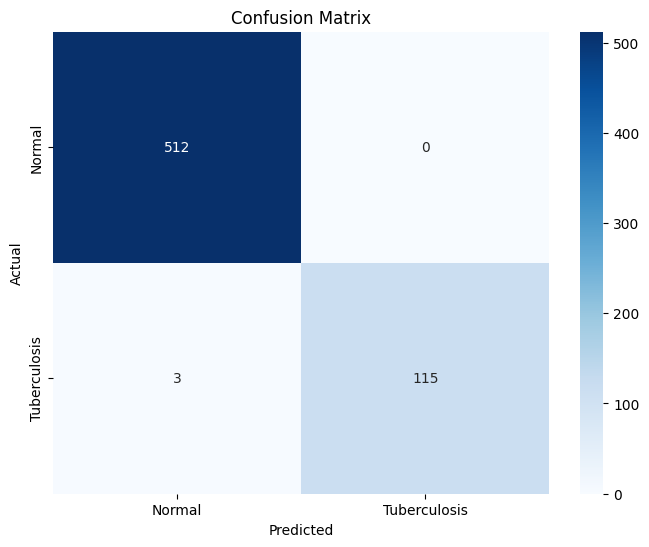

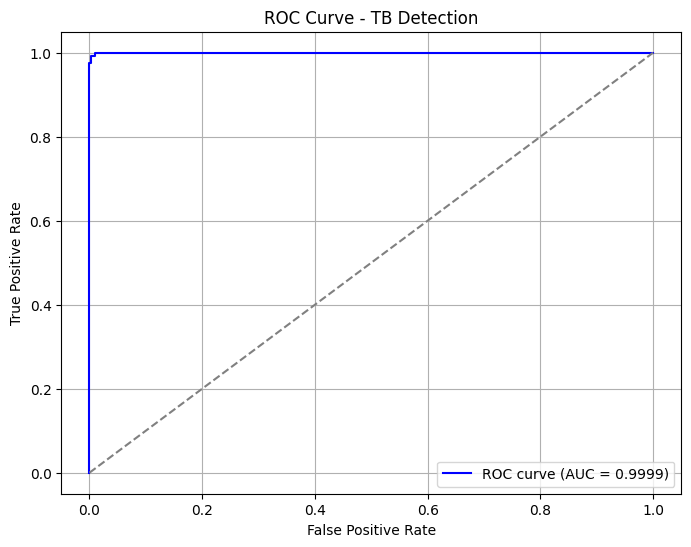

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_labels = []
all_preds = []
all_probs = []


with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs[:,1].cpu().numpy())

# ---- Classification report ----
print(classification_report(all_labels, all_preds, target_names=datasets.classes))


# ---- Confusion matrix ----
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=datasets.classes, yticklabels=datasets.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ---- ROC curve and AUC ----
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TB Detection')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()





In [26]:
# Save the model's state dictionary
torch.save(model.state_dict(), "tb_detector_densenet121.pth")
print("Model saved successfully!")


Model saved successfully!
